In [1]:
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
height= 224
width= 224
batch_size= 32

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,)


test_datagen = ImageDataGenerator(rescale=1./255,)

In [5]:
train_dir= 'dataset/train'
test_dir= 'dataset/test'

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size= batch_size,
    class_mode='categorical',
    shuffle=True,
)

test_generator= test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size= batch_size,
    class_mode='categorical',
    shuffle=False,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [8]:
total_image = np.concatenate([train_generator.labels,test_generator.labels])

In [9]:
print('angry_class:', len(np.where(total_image==0)[0]))
print('disgust_class:', len(np.where(total_image==1)[0]))
print('fear_class:', len(np.where(total_image==2)[0]))
print('happy_class:', len(np.where(total_image==3)[0]))
print('neutral_class:', len(np.where(total_image==4)[0]))
print('sad_class:', len(np.where(total_image==5)[0]))
print('surprise_class:', len(np.where(total_image==6)[0]))

angry_class: 4953
disgust_class: 547
fear_class: 5121
happy_class: 8989
neutral_class: 6198
sad_class: 6077
surprise_class: 4002


In [10]:
images, labels = next(train_generator)

In [11]:
images.shape

(32, 224, 224, 3)

In [12]:
labels.shape

(32, 7)

In [13]:
def plot_images(images_arr, labels_arr):

    random.seed(4)

    images_labels = list(zip(images_arr, labels_arr))

    five_images = random.sample(images_labels, 5)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))

    class_names = list(train_generator.class_indices.keys())
    
    for ax, (img, lbl) in zip(axes, five_images):
        if isinstance(lbl, (list, np.ndarray)):
            lbl = lbl[0]  # Adjust this based on your label format
        ax.imshow(img)
        ax.set_title(class_names[int(lbl)])
        # ax.axis('off')

    plt.tight_layout()
    plt.show()

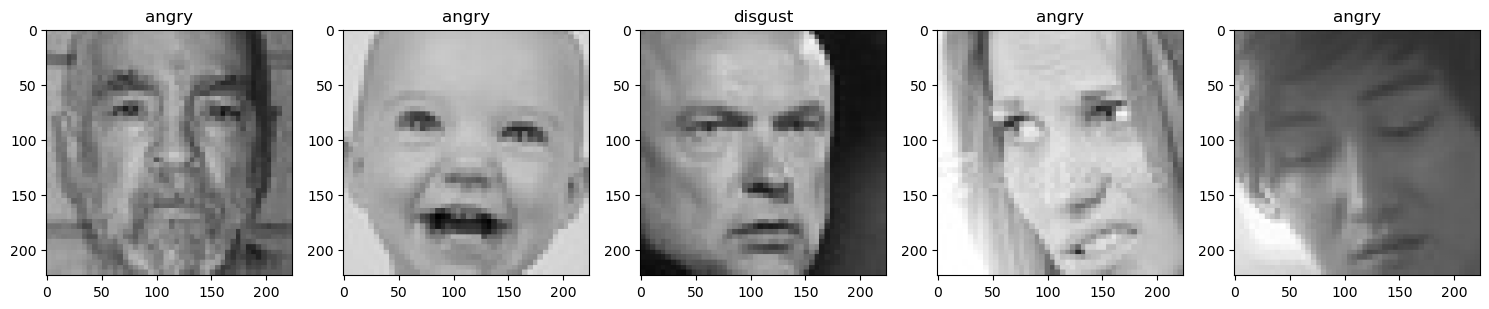

In [14]:
plot_images(images, labels)

In [15]:
# from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras import backend as K

In [16]:
# model = Sequential()

# model.add(Conv2D(32, kernel_size=(3,3), activation= 'relu', input_shape=(height, width, 1)))
# model.add(Conv2D(64, kernel_size=(3,3), activation= 'relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, kernel_size=(3,3), activation= 'relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(128, kernel_size=(3,3), activation= 'relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(1024, activation= 'relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation= 'softmax'))

In [17]:
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow import keras

In [18]:
tf.keras.backend.clear_session()

In [19]:
base_model = VGGFace(weights='vggface', include_top=False, input_shape=(height, width, 3))

In [20]:
base_model.summary()

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [21]:
for layer in base_model.layers:
    layer.trainable = False

In [22]:
num_classes = len(np.unique(labels))
num_classes

2

In [23]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_vgg16 (Functional)  (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

In [25]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [26]:
# checkpoint = ModelCheckpoint('vggface_best_weights.keras',
#                              monitor='val_accuracy',
#                              verbose=1,
#                              mode='max',
#                              save_best_only=True)

# early = EarlyStopping(monitor="val_loss",
#                       mode="min",
#                       restore_best_weights=True,
#                       patience=5)

# callbacks_list = [checkpoint]

In [27]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator
    )

Epoch 1/50
898/898 [==============================] - 267s 286ms/step - loss: 1.3817 - accuracy: 0.4768 - val_loss: 1.1727 - val_accuracy: 0.5578
Epoch 2/50
898/898 [==============================] - 135s 151ms/step - loss: 1.1934 - accuracy: 0.5556 - val_loss: 1.1327 - val_accuracy: 0.5765
Epoch 3/50
898/898 [==============================] - 119s 133ms/step - loss: 1.1487 - accuracy: 0.5709 - val_loss: 1.1005 - val_accuracy: 0.5855
Epoch 4/50
898/898 [==============================] - 123s 138ms/step - loss: 1.1172 - accuracy: 0.5861 - val_loss: 1.0924 - val_accuracy: 0.5871
Epoch 5/50
898/898 [==============================] - 118s 132ms/step - loss: 1.0978 - accuracy: 0.5892 - val_loss: 1.0659 - val_accuracy: 0.5964
Epoch 6/50
898/898 [==============================] - 117s 131ms/step - loss: 1.0762 - accuracy: 0.5999 - val_loss: 1.0615 - val_accuracy: 0.5978
Epoch 7/50
898/898 [==============================] - 119s 132ms/step - loss: 1.0643 - accuracy: 0.6040 - val_loss: 1.0458 -

In [28]:
# history = model.fit(
#     train_generator, 
#     epochs=50, 
#     steps_per_epoch= 28709//64,
#     validation_data= test_generator,
#     validation_steps= 7178//64, 
#     )

In [29]:
model_json= model.to_json()

with open('model/emotional_model_final_cate.json', 'w') as json_file:
    json_file.write(model_json)

In [30]:
model.save_weights('model/emotional_model_final_cate_weights.h5')

In [31]:
def plot_learning_curve(history, metrics):
    acc = history.history[metrics]
    val_acc = history.history[f'val_{metrics}']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(5,3))
    plt.plot(epochs, acc, label=f'training {metrics}')
    plt.plot(epochs, val_acc, label=f'validation {metrics}')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend()

    plt.figure(figsize=(5,3))
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

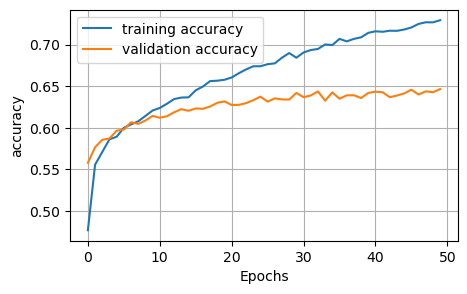

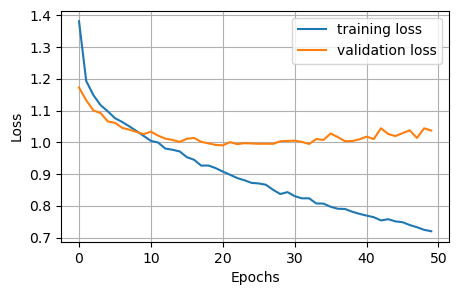

In [32]:
plot_learning_curve(history, metrics='accuracy')

In [33]:
train_result = model.evaluate(train_generator)
test_result = model.evaluate(test_generator)

225/225 [==============================] - 21s 91ms/step - loss: 1.0372 - accuracy: 0.6464


In [34]:
print(f"Train Loss: {np.round(train_result[0], 4)}")
print(f"Test Loss: {np.round(test_result[0], 4)}")
print(f"Train Accuracy: {np.round(train_result[1], 3)}")
print(f"Test Accuracy: {np.round(test_result[1], 3)}")

Train Loss: 0.528
Test Loss: 1.0372
Train Accuracy: 0.816
Test Accuracy: 0.646


In [35]:
y_pred_probs = model.predict(test_generator)
print(y_pred_probs.shape)

225/225 [==============================] - 20s 89ms/step
(7178, 7)


In [36]:
y_true = test_generator.classes
y_true

array([0, 0, 0, ..., 6, 6, 6])

In [37]:
classes_names = list(test_generator.class_indices.keys())

In [38]:
# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
# Calculate confusion matrix
confusion = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", confusion)
# Calculate perfect confusion matrix
p_confusion = confusion_matrix(y_true, y_true)
print("Perfect Confusion Matrix:\n", p_confusion)
# Calculate precision, recall, and f1-score
report = classification_report(y_true, y_pred, target_names=classes_names)
print("\nClassification Report:\n", report)

Confusion Matrix:
 [[ 608    3   63   51   85  113   35]
 [  35   51    7    4    2   11    1]
 [ 157    4  348   46  109  225  135]
 [  52    1   23 1508   91   60   39]
 [  74    2   66   81  799  178   33]
 [ 158    8  132   59  200  660   30]
 [  18    0   55   56   24   12  666]]
Perfect Confusion Matrix:
 [[ 958    0    0    0    0    0    0]
 [   0  111    0    0    0    0    0]
 [   0    0 1024    0    0    0    0]
 [   0    0    0 1774    0    0    0]
 [   0    0    0    0 1233    0    0]
 [   0    0    0    0    0 1247    0]
 [   0    0    0    0    0    0  831]]

Classification Report:
               precision    recall  f1-score   support

       angry       0.55      0.63      0.59       958
     disgust       0.74      0.46      0.57       111
        fear       0.50      0.34      0.41      1024
       happy       0.84      0.85      0.84      1774
     neutral       0.61      0.65      0.63      1233
         sad       0.52      0.53      0.53      1247
    surprise    

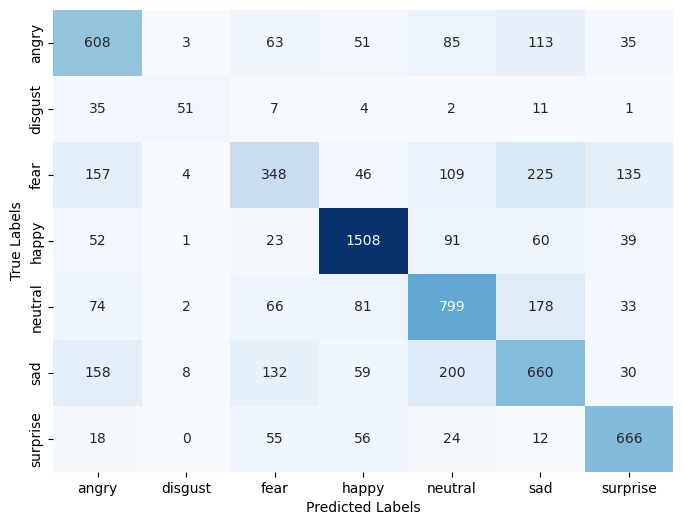

In [39]:
plt.figure(figsize=(8, 6))
hmap = sns.heatmap(confusion, annot=True, vmin=0,
                 fmt='g', cmap='Blues', cbar=False,
                 xticklabels=classes_names,
                 yticklabels=classes_names)

hmap.set(xlabel='Predicted Labels')
hmap.set(ylabel='True Labels')
plt.show()